In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess Data
# Load dataset
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years: potential change
df = yf.download('TSLA', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

# Step 2: Create Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
# df['rolling_diff_10'] = df['Close'] - df['rolling_mean_10']
df.dropna(inplace=True)

# Step 3: Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

[*********************100%***********************]  1 of 1 completed


In [ ]:
print(df.head())

Price                          Close      lag_5 rolling_mean_10 rolling_sd_10
Ticker                          TSLA                                         
Date                                                                         
2019-11-29 00:00:00+00:00  21.996000  23.655333       22.855067      0.795048
2019-12-02 00:00:00+00:00  22.324667  22.202667       22.739733      0.778115
2019-12-03 00:00:00+00:00  22.413334  22.422667       22.647800      0.754219
2019-12-04 00:00:00+00:00  22.202000  21.927999       22.471200      0.602177
2019-12-05 00:00:00+00:00  22.024668  22.086000       22.325533      0.497816


In [ ]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 1
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
X_train

tensor([[[0.0000, 0.0045, 0.0018, 0.0152]],

        [[0.0008, 0.0007, 0.0015, 0.0147]],

        [[0.0011, 0.0013, 0.0012, 0.0141]],

        ...,

        [[0.4018, 0.2873, 0.3302, 0.4171]],

        [[0.3729, 0.3139, 0.3424, 0.4240]],

        [[0.3898, 0.3143, 0.3540, 0.4530]]])

In [ ]:
len(train_loader.dataset)

798

Here we finetune the model by changing the layer, learning rate and epochs to get the a very precise prediction model.  

In [ ]:
# Step 6: Build the RNN Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True) # Change in the layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters(),lr=0.001) # Change the learning rate here

# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50 # Potential change
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

# Step 8: Evaluate the Model
# Evaluate on testing set
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/50, Train Loss: 0.003418, Valid Loss: 0.061181
Epoch 4/50, Train Loss: 0.003469, Valid Loss: 0.055736
Epoch 6/50, Train Loss: 0.003231, Valid Loss: 0.046016
Epoch 8/50, Train Loss: 0.002822, Valid Loss: 0.029575
Epoch 10/50, Train Loss: 0.002678, Valid Loss: 0.013165
Epoch 12/50, Train Loss: 0.002464, Valid Loss: 0.010445
Epoch 14/50, Train Loss: 0.002399, Valid Loss: 0.008518
Epoch 16/50, Train Loss: 0.002069, Valid Loss: 0.007252
Epoch 18/50, Train Loss: 0.001796, Valid Loss: 0.006964
Epoch 20/50, Train Loss: 0.001533, Valid Loss: 0.007295
Epoch 22/50, Train Loss: 0.001422, Valid Loss: 0.007491
Epoch 24/50, Train Loss: 0.001441, Valid Loss: 0.008164
Epoch 26/50, Train Loss: 0.001366, Valid Loss: 0.011161
Epoch 28/50, Train Loss: 0.001407, Valid Loss: 0.008059
Epoch 30/50, Train Loss: 0.001304, Valid Loss: 0.008565
Epoch 32/50, Train Loss: 0.001360, Valid Loss: 0.009041
Epoch 34/50, Train Loss: 0.001318, Valid Loss: 0.009856
Epoch 36/50, Train Loss: 0.001323, Valid Loss: 0.011

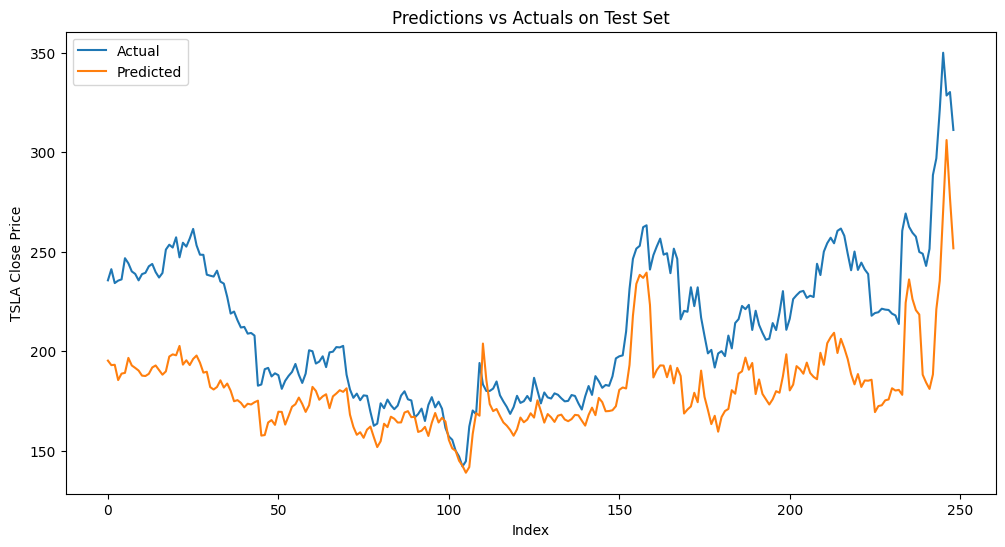

In [ ]:
# Step 9: Denormalize and Visualize Predictions
# Since we have multiple features, we need to only inverse transform the target variable
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data
    data = scaler.inverse_transform(data)
    return data[:, index]

# Denormalize the predictions and actuals
test_preds_denorm = denormalize(test_preds.flatten(), scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.flatten(), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

In [ ]:
# Step 10: Save and Load the Model
# Save the model
torch.save(model.state_dict(), 'tsla_rnn_model.pth')

# Load the model
loaded_model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)
loaded_model.load_state_dict(torch.load('tsla_rnn_model.pth'))
loaded_model.to(device)
loaded_model.eval()

<ipython-input-24-f0e12f2f4dff>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('tsla_rnn_model.pth'))


RNNModel(
  (rnn): RNN(4, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
# Combine the parameters of the RNN layer and linear layer
params = list(model.parameters())

# Print the number of parameters
print("Number of parameters:", sum(p.numel() for p in params))

# Print the shapes of the parameters
for name, param in model.named_parameters():
    print("Name: ", name)
    print("shape: ", param.shape)
    print("Weight: ", param.data)